In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from uci_helpers import uci_loader, uci_reps
import argparse
import pandas as pd
import os
import sys
from rpp.rpp_conv import RPPConv, RPPConv_L2, RPPConv_L1, ConvNet, LinearNet

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def compute_mse(model, loader):
    loss_func = torch.nn.MSELoss()
    mse = 0
    n_data = len(loader.dataset)
    for x, y in loader:
        x, y = x.cuda(), y.cuda()
        mse += x.shape[0] * loss_func(model(x).squeeze(), y)
    return mse.div(n_data).item()

In [3]:
epochs = 1000
lr = 0.001

num_layers=4
ch=32

batch_size = 128
conv_wd = 0.0001
basic_wd = 0.01

dataset = 'fertility'
network = 'mlp'

reg_fun = "l2"
save_every = 10

In [4]:
kwargs = uci_reps[dataset]
if network.lower() == 'rpp':
    print("Using RPP")
    model = RPPConv(num_layers, ch, **kwargs).cuda()
elif network.lower() == "conv":
    print("Using Conv")
    model = ConvNet(num_layers, ch, **kwargs).cuda()
else:
    print("Using MLP")
    model = LinearNet(num_layers, ch, **kwargs).cuda()

tr_x, tr_y, te_x, te_y = uci_loader(dataset)
n_train = tr_x.shape[0]
n_test = te_x.shape[0]

trainset = TensorDataset(tr_x, tr_y)
trainloader = DataLoader(trainset, batch_size, pin_memory=True, num_workers=4)

testset = TensorDataset(te_x, te_y)
testloader = DataLoader(testset, batch_size, pin_memory=True, num_workers=4)

Using MLP


In [5]:
x, y = next(iter(trainloader))

In [6]:
x.shape

torch.Size([80, 1, 3, 3])

In [7]:
len(trainset)

80

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
loss_func = torch.nn.MSELoss()
if reg_fun.lower() == 'l1':
    regularizer = RPPConv_L1
else:
    regularizer = RPPConv_L2

logger = []
losses = []
for epoch in range(epochs):
    for x, y in trainloader:
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        outputs = model(x)
        loss=loss_func(outputs.squeeze(), y)
        losses.append(loss.item())
        if network.lower() == 'rpp':
            loss += regularizer(model, conv_wd=conv_wd, 
                  basic_wd=basic_wd)
        loss.backward()
        optimizer.step()        
        scheduler.step()

    if (epoch % save_every == 0) or (epoch == epochs-1):
        with torch.no_grad():
            tr_mse = compute_mse(model, trainloader)
            te_mse = compute_mse(model, testloader)

        logger.append([epoch, tr_mse, te_mse])
        print(logger[-1])
## Save Outputs ##
df = pd.DataFrame(logger)
df.columns = ['epoch', 'tr_mse', 'te_mse']

[0, 0.034006115049123764, 0.03537648916244507]
[10, 0.01447839941829443, 0.043078094720840454]
[20, 0.007752757053822279, 0.05553803965449333]
[30, 0.004489687737077475, 0.050658345222473145]
[40, 0.003519230056554079, 0.052103012800216675]
[50, 0.0029008358251303434, 0.054779913276433945]
[60, 0.002579576103016734, 0.055281247943639755]
[70, 0.0023131442721933126, 0.05658991262316704]
[80, 0.002117357449606061, 0.0578983835875988]
[90, 0.002131856745108962, 0.058959852904081345]
[100, 0.0020873122848570347, 0.06092583015561104]
[110, 0.0019881564658135176, 0.059889037162065506]
[120, 0.0019990254659205675, 0.06233615800738335]
[130, 0.0018633430590853095, 0.06125914677977562]
[140, 0.0018714688485488296, 0.06376035511493683]
[150, 0.001741118379868567, 0.06235954910516739]
[160, 0.001698190695606172, 0.06435506790876389]
[170, 0.0017274875426664948, 0.06376013904809952]
[180, 0.0016401391476392746, 0.06587303429841995]
[190, 0.0015283037209883332, 0.06448446959257126]
[200, 0.00153315

In [9]:
df = pd.DataFrame(logger)
df.columns = ['epoch', 'tr_mse', 'te_mse']

<AxesSubplot:xlabel='epoch', ylabel='te_mse'>

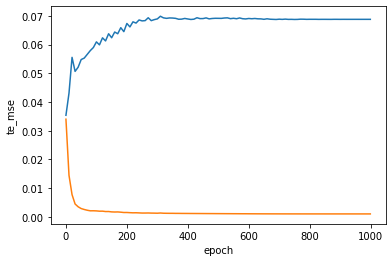

In [10]:
sns.lineplot(x='epoch', y='te_mse', data=df)
sns.lineplot(x='epoch', y='tr_mse', data=df)